In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from itertools import product
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import seaborn as sns
from codecarbon import EmissionsTracker, track_emissions

In [2]:
def load_data_by_dimension(dimension):
    root = "./datasets/"
    data_filename = root + f'kryptonite-{dimension}-X.npy'
    labels_filename = root + f'kryptonite-{dimension}-y.npy'

    try:
        data = np.load(data_filename)
        labels = np.load(labels_filename)
        print(f"Loaded dataset with dimension {dimension}. Data shape: {data.shape}, Labels shape: {labels.shape}")
        return data, labels
    except FileNotFoundError:
        print(f"Dataset for dimension {dimension} not found.")
        return None, None

# Experiment 1: KNN Performance

## Grid Search

In [30]:
def find_best_knn_params(data, labels, search_grid=np.arange(1, 30, 2)):
    # Define the parameter grid for k in kNN
    param_grid = {'n_neighbors': search_grid, 'weights': ["uniform", "distance"]}
    # Initialize the KNeighborsClassifier
    knn = KNeighborsClassifier()
    # Use GridSearchCV to find the best parameter
    grid_search = GridSearchCV(knn, param_grid, cv=5)
    grid_search.fit(data, labels)
    return grid_search.best_params_['n_neighbors'], grid_search.best_score_, grid_search.best_params_['weights']

In [ ]:
dimensions = [9, 12, 15, 18, 24, 30, 45]
best_ks = []
accuracies = []
weights = []
tracker = EmissionsTracker()
tracker.start()
for dim in dimensions:
    data, labels = load_data_by_dimension(dim)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

    # find best k
    best_k, best_acc, w = find_best_knn_params(X_train, y_train)
    print(f"Best k for dimension {dim}: {best_k}, weight: {w} with accuracy {best_acc}")
    best_ks.append(best_k)
    weights.append(w)
emissions = tracker.stop()
print(best_ks)
print(weights)

Loaded dataset with dimension 9. Data shape: (18000, 9), Labels shape: (18000,)
Best k for dimension 9: 9, weight: uniform with accuracy 0.9584722222222222
Loaded dataset with dimension 12. Data shape: (24000, 12), Labels shape: (24000,)
Best k for dimension 12: 1, weight: uniform with accuracy 0.9111979166666666
Loaded dataset with dimension 15. Data shape: (30000, 15), Labels shape: (30000,)
Best k for dimension 15: 3, weight: distance with accuracy 0.508375
Loaded dataset with dimension 18. Data shape: (36000, 18), Labels shape: (36000,)
Best k for dimension 18: 29, weight: distance with accuracy 0.5305208333333333
Loaded dataset with dimension 24. Data shape: (48000, 24), Labels shape: (48000,)
Best k for dimension 24: 3, weight: distance with accuracy 0.5038020833333333
Loaded dataset with dimension 30. Data shape: (60000, 30), Labels shape: (60000,)
Best k for dimension 30: 7, weight: uniform with accuracy 0.5064583333333333
Loaded dataset with dimension 45. Data shape: (90000, 4

## Evaluation

In [32]:
dimensions = [9, 12, 15, 18, 24, 30, 45]
means = []
std_devs = []
random_seeds = [42, 123, 456, 789, 1010, 2020, 3030, 4040, 5050, 6060]
for dim, k, w in zip(dimensions, best_ks, weights):
    data, labels = load_data_by_dimension(dim)
    accuracies = []
    for seed in random_seeds:
        X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=seed)

        model = KNeighborsClassifier(n_neighbors=k, weights=w)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    means.append(np.mean(accuracies))
    std_devs.append(np.std(accuracies))

Loaded dataset with dimension 9. Data shape: (18000, 9), Labels shape: (18000,)
Loaded dataset with dimension 12. Data shape: (24000, 12), Labels shape: (24000,)
Loaded dataset with dimension 15. Data shape: (30000, 15), Labels shape: (30000,)
Loaded dataset with dimension 18. Data shape: (36000, 18), Labels shape: (36000,)
Loaded dataset with dimension 24. Data shape: (48000, 24), Labels shape: (48000,)
Loaded dataset with dimension 30. Data shape: (60000, 30), Labels shape: (60000,)
Loaded dataset with dimension 45. Data shape: (90000, 45), Labels shape: (90000,)


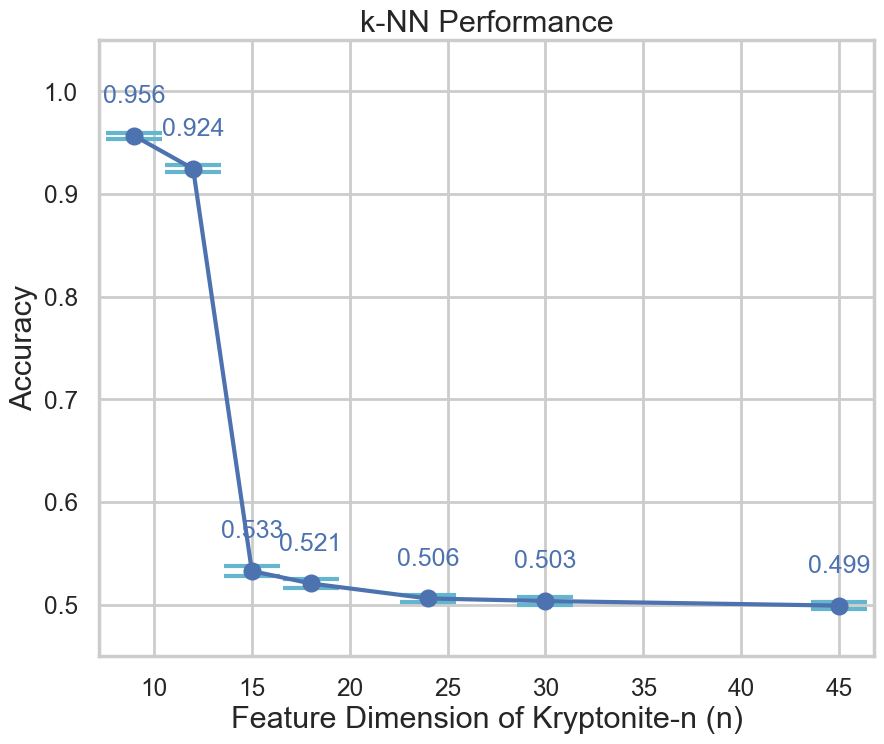

In [102]:
plt.rcdefaults()
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")
sns.set_context("poster", font_scale=0.8)
plt.errorbar(dimensions, means, yerr=std_devs, marker='o', linestyle='-', color='b', ecolor='c', capsize=20, capthick=3)
for x, y in zip(dimensions, means):
    plt.text(x, y + 0.05, f'{y:.3f}', ha='center', va='top', color='b', fontsize=18)

plt.xlabel("Feature Dimension of Kryptonite-n (n)", fontsize=22)
plt.ylabel('Accuracy', fontsize=22)
plt.title('k-NN Performance', fontsize=22)
plt.grid(True)
plt.ylim(0.45, 1.05)
plt.show()

# Experiment 2: KNN with Feature Selection

Loaded dataset with dimension 9. Data shape: (18000, 9), Labels shape: (18000,)
Loaded dataset with dimension 12. Data shape: (24000, 12), Labels shape: (24000,)
Loaded dataset with dimension 15. Data shape: (30000, 15), Labels shape: (30000,)
Loaded dataset with dimension 18. Data shape: (36000, 18), Labels shape: (36000,)
Loaded dataset with dimension 24. Data shape: (48000, 24), Labels shape: (48000,)
Loaded dataset with dimension 30. Data shape: (60000, 30), Labels shape: (60000,)
Loaded dataset with dimension 45. Data shape: (90000, 45), Labels shape: (90000,)


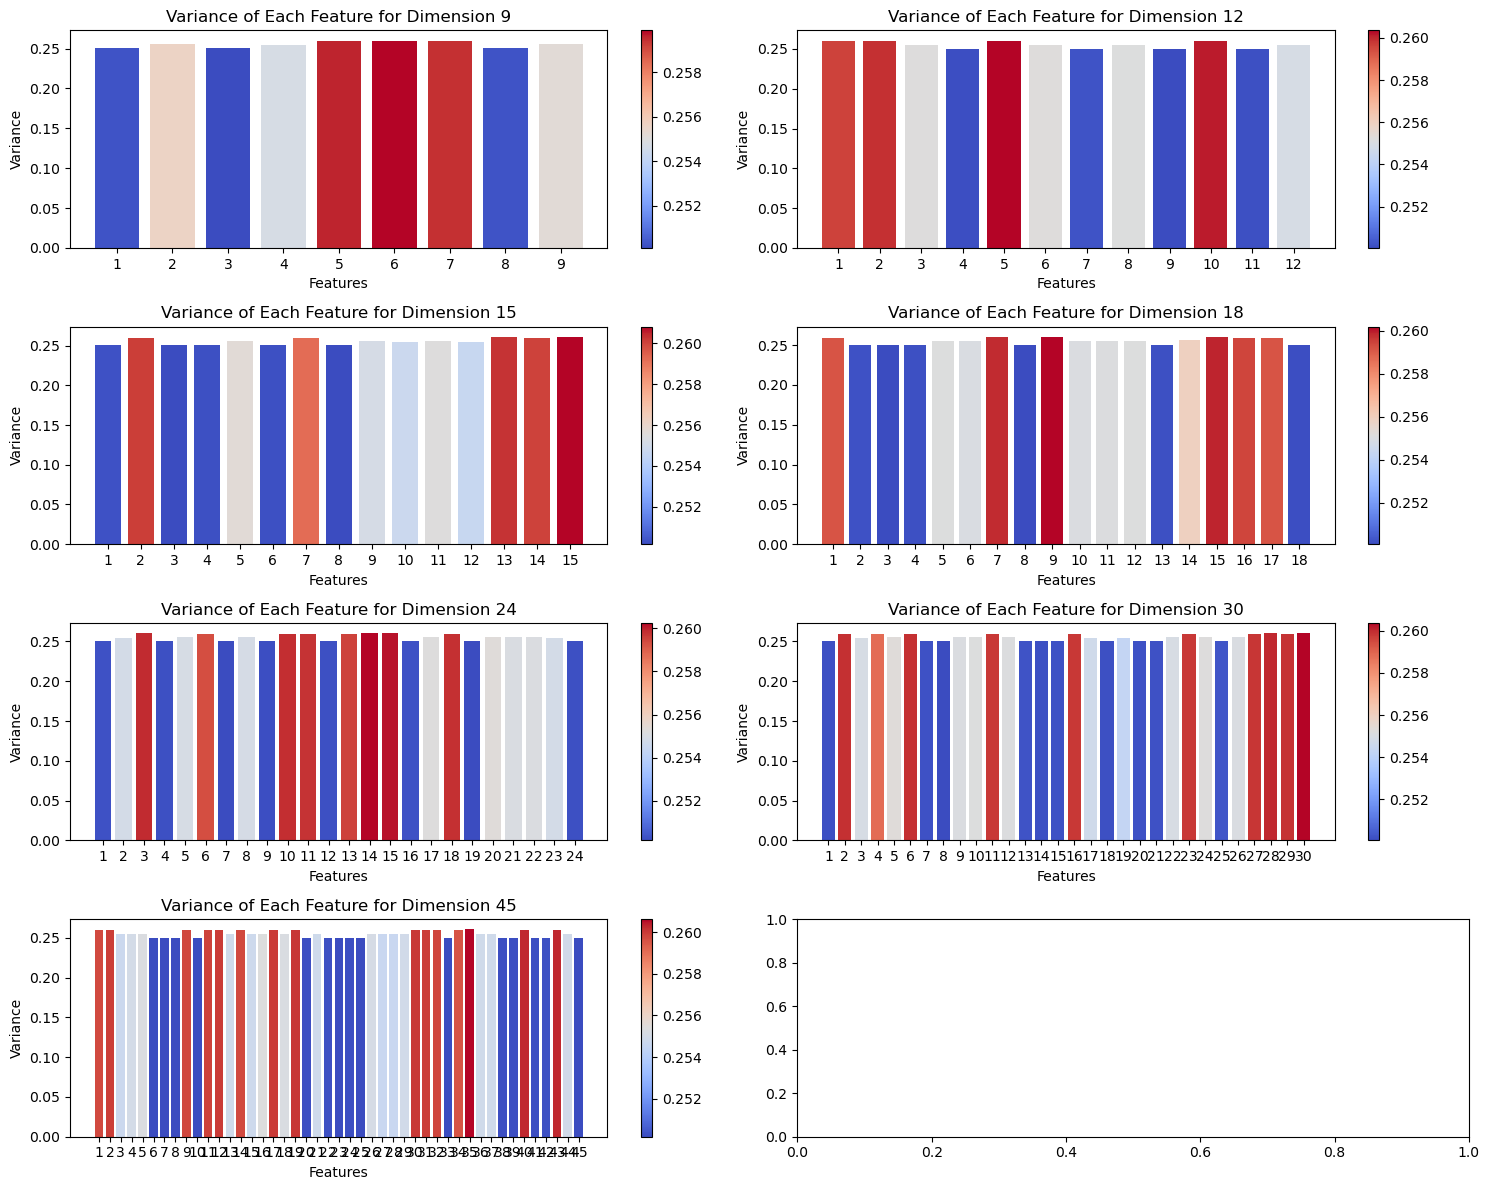

In [31]:
dimensions = [9, 12, 15, 18, 24, 30, 45]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 12))

axes = axes.flatten()
for i, dim in enumerate(dimensions):
    data, labels = load_data_by_dimension(dim)
    # data = scaler.fit_transform(data)
    df = pd.DataFrame(data, columns=[f"{i + 1}" for i in range(data.shape[1])])
    df['Label'] = labels
    variances = df.drop('Label', axis=1).var()
    norm = plt.Normalize(variances.min(), variances.max())
    cmap = plt.get_cmap("coolwarm")
    colors = cmap(norm(variances.values))

    bars = axes[i].bar(variances.index, variances.values, color=colors)
    # axes[i].bar(variances.index, variances.values)
    axes[i].set_title(f'Variance of Each Feature for Dimension {dim}')
    axes[i].set_xlabel('Features')
    axes[i].set_ylabel('Variance')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=axes[i])

plt.tight_layout()
plt.show()


## Grid search for variance threshold and K

In [39]:
def preprocess_data(data, variance_threshold):
    variances = np.var(data, axis=0)
    return data[:, variances >= variance_threshold]

In [54]:
@track_emissions(project_name="KNNvariance")
def perform_grid_search(dim, k_range):
    data, labels = load_data_by_dimension(dim)
    thresholds = list(np.sort(np.var(data, axis=0)))
    accuracies = {t: [] for t in thresholds}
    best_acc = 0
    best_params = {}

    for t, k in product(thresholds, k_range):
        data_processed = preprocess_data(data, variance_threshold=t)
        X_train, X_test, y_train, y_test = train_test_split(data_processed, labels, test_size=0.2, random_state=42)

        model = KNeighborsClassifier(n_neighbors=k)
        acc = np.mean(cross_val_score(model, X_train, y_train, cv=5))
        accuracies[t].append(acc)
        if acc > best_acc:
            best_acc = acc
            best_params = {"Threshold": t, "K": k}

    plt.figure(figsize=(10, 6))
    for t in thresholds:
        plt.plot(k_range, accuracies[t], label=f"Threshold {t}")

    plt.title(f"Accuracy vs K for Dimension {dim}")
    plt.xlabel("K")
    plt.ylabel("Accuracy")
    # plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    plt.show()
    return best_params, best_acc

In [56]:
k_range = range(1, 50, 2)

Loaded dataset with dimension 9. Data shape: (18000, 9), Labels shape: (18000,)


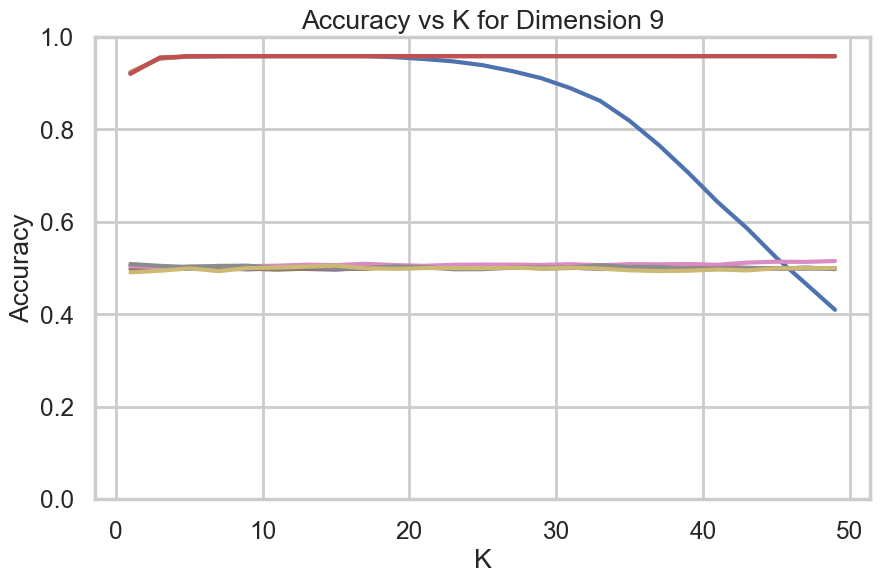

Best combination for Dimension 9:
Threshold: 0.25009819865226746, K: 9, Accuracy: 0.9584722222222222


In [57]:
best_params, best_acc = perform_grid_search(9, k_range)
print(f"Best combination for Dimension 9:")
print(f"Threshold: {best_params['Threshold']}, K: {best_params['K']}, Accuracy: {best_acc}")

Loaded dataset with dimension 12. Data shape: (24000, 12), Labels shape: (24000,)


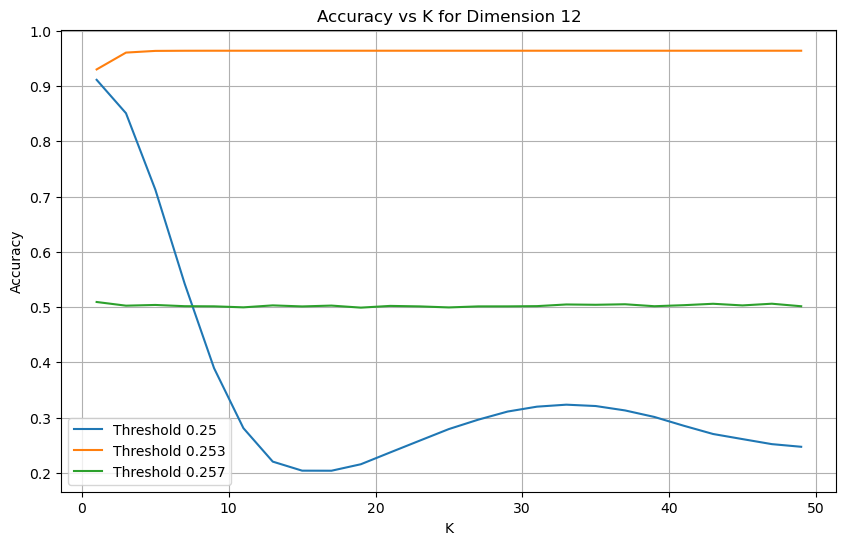

Best combination for Dimension 12:
Threshold: 0.253, K: 9, Accuracy: 0.9638541666666667


In [22]:
best_params, best_acc = perform_grid_search(12, k_range)
print(f"Best combination for Dimension 12:")
print(f"Threshold: {best_params['Threshold']}, K: {best_params['K']}, Accuracy: {best_acc}")

Loaded dataset with dimension 15. Data shape: (30000, 15), Labels shape: (30000,)


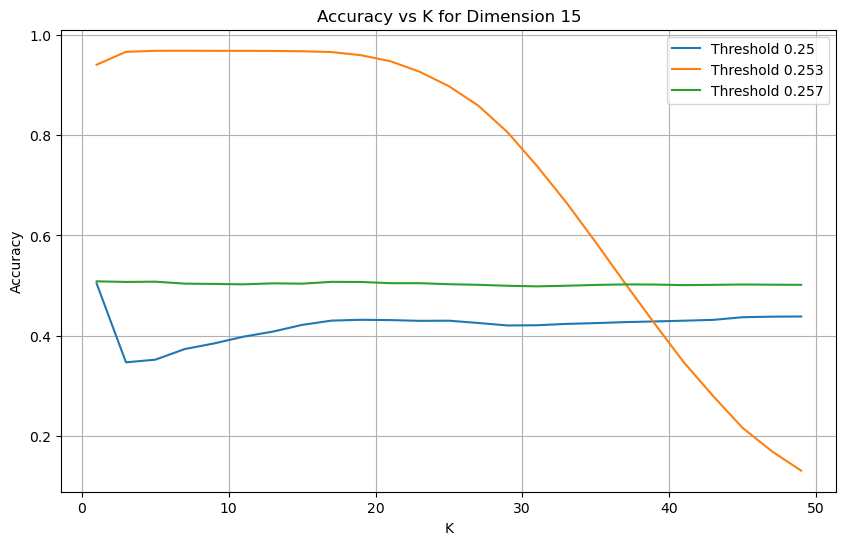

Best combination for Dimension 15:
Threshold: 0.253, K: 7, Accuracy: 0.9681666666666666


In [23]:
best_params, best_acc = perform_grid_search(15, k_range)
print(f"Best combination for Dimension 15:")
print(f"Threshold: {best_params['Threshold']}, K: {best_params['K']}, Accuracy: {best_acc}")

Loaded dataset with dimension 18. Data shape: (36000, 18), Labels shape: (36000,)


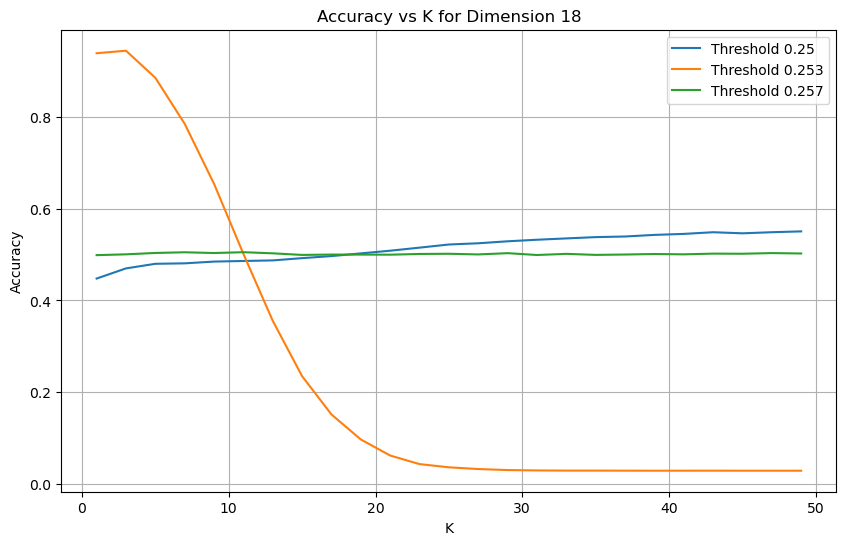

Best combination for Dimension 18:
Threshold: 0.253, K: 3, Accuracy: 0.9441666666666666


In [24]:
best_params, best_acc = perform_grid_search(18, k_range)
print(f"Best combination for Dimension 18:")
print(f"Threshold: {best_params['Threshold']}, K: {best_params['K']}, Accuracy: {best_acc}")

Loaded dataset with dimension 24. Data shape: (48000, 24), Labels shape: (48000,)


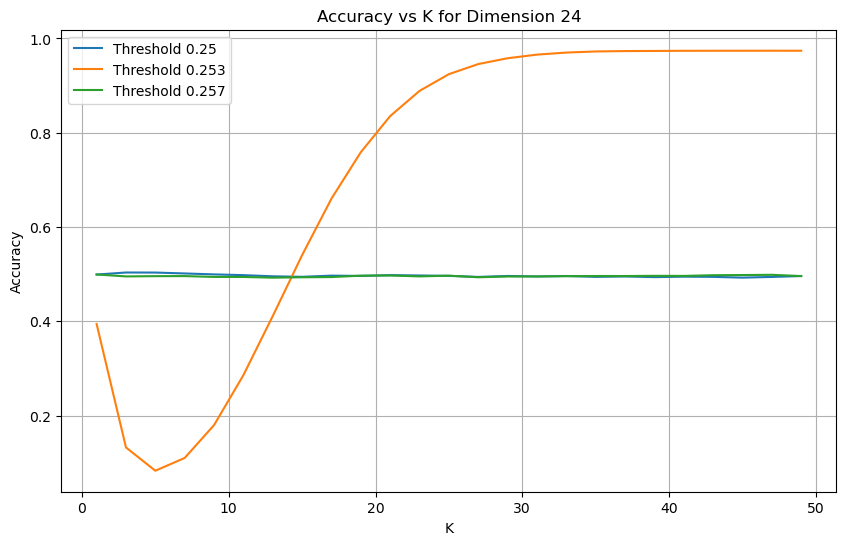

Best combination for Dimension 24:
Threshold: 0.253, K: 47, Accuracy: 0.9738541666666667


In [25]:
best_params, best_acc = perform_grid_search(24, k_range)
print(f"Best combination for Dimension 24:")
print(f"Threshold: {best_params['Threshold']}, K: {best_params['K']}, Accuracy: {best_acc}")

Loaded dataset with dimension 30. Data shape: (60000, 30), Labels shape: (60000,)


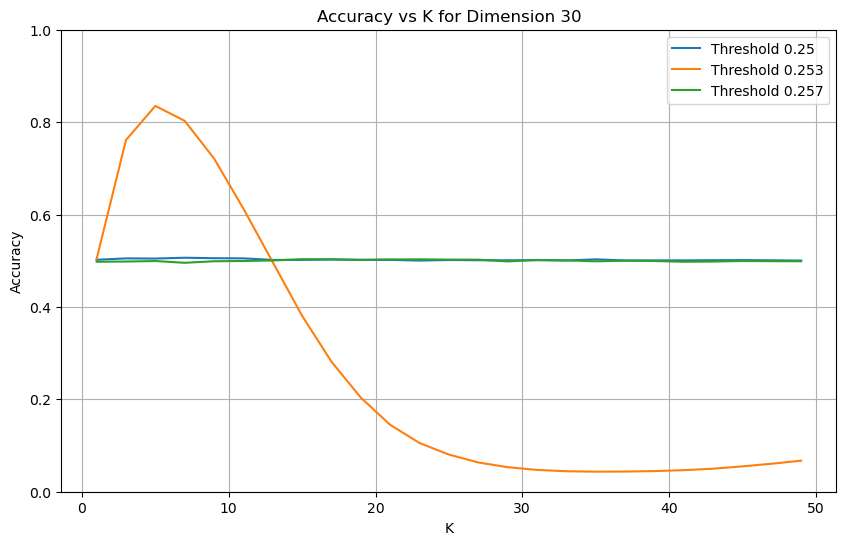

Best combination for Dimension 30:
Threshold: 0.253, K: 5, Accuracy: 0.8350625


In [27]:
best_params, best_acc = perform_grid_search(30, k_range)
print(f"Best combination for Dimension 30:")
print(f"Threshold: {best_params['Threshold']}, K: {best_params['K']}, Accuracy: {best_acc}")

Loaded dataset with dimension 45. Data shape: (90000, 45), Labels shape: (90000,)


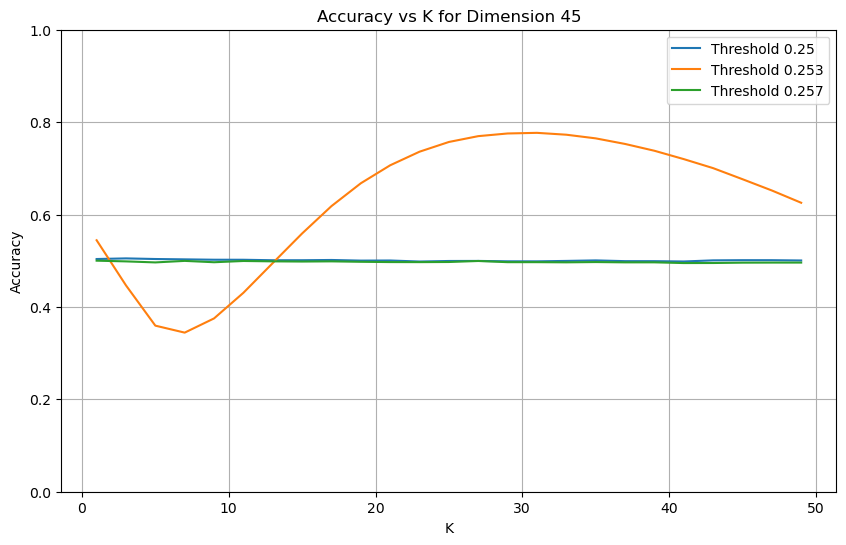

Best combination for Dimension 45:
Threshold: 0.253, K: 31, Accuracy: 0.7767916666666668


In [28]:
best_params, best_acc = perform_grid_search(45, k_range)
print(f"Best combination for Dimension 45:")
print(f"Threshold: {best_params['Threshold']}, K: {best_params['K']}, Accuracy: {best_acc}")

## Evaluation

In [34]:
dimensions = [9, 12, 15, 18, 24, 30, 45]
best_ks = [9, 9, 7, 3, 47, 35, 31]
means_reduction = []
std_devs_reduction = []
random_seeds = [42, 123, 456, 789, 1010, 2020, 3030, 4040, 5050, 6060]
for dim, k in zip(dimensions, best_ks):
    data, labels = load_data_by_dimension(dim)
    data = preprocess_data(data, variance_threshold=0.253)
    accuracies = []
    for seed in random_seeds:
        X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=seed)
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        if dim in [
            30]:  # the model basically predicts the label the datapoint is not in at dim=30 and k=45, thus should flip the output
            y_pred = 1 - y_pred
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    means_reduction.append(np.mean(accuracies))
    std_devs_reduction.append(np.std(accuracies))

Loaded dataset with dimension 9. Data shape: (18000, 9), Labels shape: (18000,)
Loaded dataset with dimension 12. Data shape: (24000, 12), Labels shape: (24000,)
Loaded dataset with dimension 15. Data shape: (30000, 15), Labels shape: (30000,)
Loaded dataset with dimension 18. Data shape: (36000, 18), Labels shape: (36000,)
Loaded dataset with dimension 24. Data shape: (48000, 24), Labels shape: (48000,)
Loaded dataset with dimension 30. Data shape: (60000, 30), Labels shape: (60000,)
Loaded dataset with dimension 45. Data shape: (90000, 45), Labels shape: (90000,)


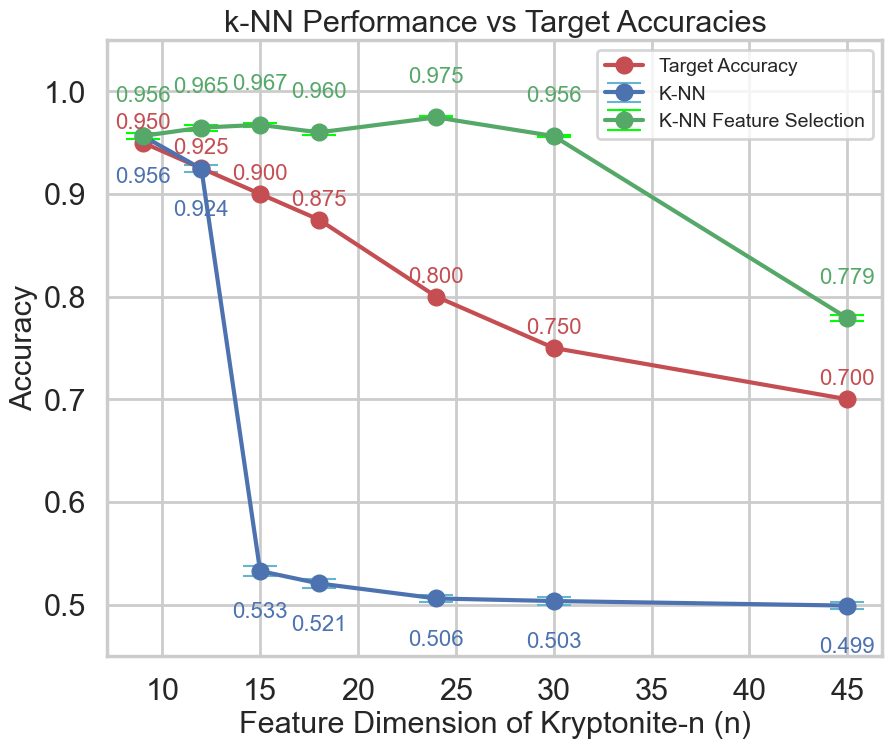

In [104]:
n = [9, 12, 15, 18, 24, 30, 45]
target_accuracies = [0.95, 0.925, 0.9, 0.875, 0.8, 0.75, 0.7]

# Plotting settings
sns.set(style="whitegrid")
sns.set_context("poster", font_scale=1)
plt.figure(figsize=(10, 8))

# Plotting kNN performance
plt.errorbar(n, means, label='K-NN', yerr=std_devs, marker='o', linestyle='-', color='b', ecolor='c', capsize=12,
             capthick=1.5)
plt.errorbar(n, means_reduction, label='K-NN Feature Selection', yerr=std_devs_reduction, marker='o', linestyle='-',
             color='g', ecolor='lime', capsize=12, capthick=1.5)

# Plotting target accuracies
plt.plot(n, target_accuracies, label='Target Accuracy', marker='o', linestyle='-', color='r')

# Annotating points for better clarity
for x, y in zip(dimensions, means):
    plt.text(x, y - 0.03, f'{y:.3f}', ha='center', va='top', color='b', fontsize=16)
for x, y in zip(dimensions, means_reduction):
    plt.text(x, y + 0.03, f'{y:.3f}', ha='center', va='bottom', color='g', fontsize=16)

for x, y in zip(n, target_accuracies):
    plt.text(x, y + 0.01, f'{y:.3f}', ha='center', va='bottom', color='r', fontsize=16)

plt.title("k-NN Performance vs Target Accuracies", fontsize=22)
plt.ylabel("Accuracy", fontsize=22)
plt.xlabel("Feature Dimension of Kryptonite-n (n)", fontsize=22)
plt.legend(fontsize=14, loc='upper right')

# Adjusting axis limits for better visual clarity
plt.ylim(0.45, 1.05)
# plt.xlim(8, 46)

# plt.tight_layout()
plt.show()


# Experiment 3: KNN performance with different distance weights

## Grid search

In [15]:
@track_emissions(project_name="KNNksearch")
def plot_optimal_k(dim, krange):
    data, labels = load_data_by_dimension(dim)
    data = preprocess_data(data, variance_threshold=0.253)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
    accuracies_distance = []
    accuracies = []
    for k in krange:
        model = KNeighborsClassifier(n_neighbors=k, weights='uniform')
        model_distance = KNeighborsClassifier(n_neighbors=k, weights='distance')
        acc = cross_val_score(model, X_train, y_train, cv=5)
        acc_distance = cross_val_score(model_distance, X_train, y_train, cv=5)
        accuracies_distance.append(np.mean(acc_distance))
        accuracies.append(np.mean(acc))
    plt.rcdefaults()
    plt.figure(figsize=(10, 5))
    plt.plot(krange, accuracies, label="uniform", marker='o', linestyle='-', color='b')
    plt.plot(krange, accuracies_distance, label="distance", marker='o', linestyle='-', color='r')
    plt.ylim(0, 1)
    plt.xlabel('Value of K')
    plt.ylabel('Accuracy')
    plt.title(f'kNN Performance for different K (dim={dim})')
    plt.legend()
    plt.grid(True)
    plt.show()

### kryptonite-9

Loaded dataset with dimension 9. Data shape: (18000, 9), Labels shape: (18000,)


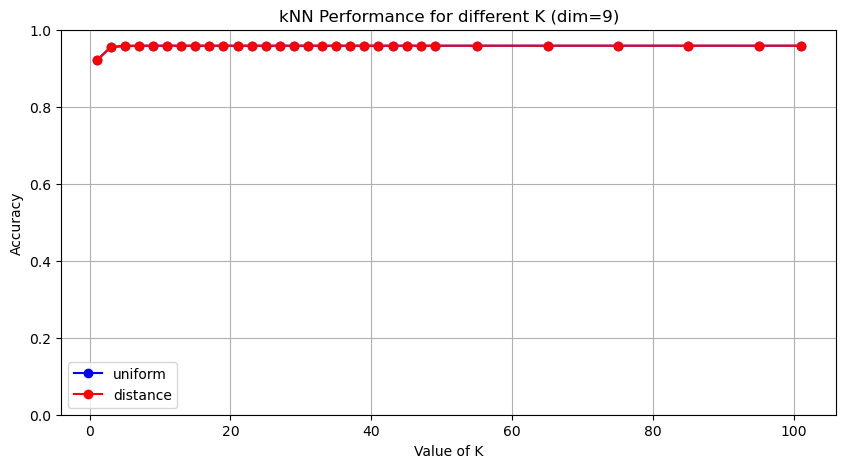

In [18]:
krange = list(range(1, 50, 2)) + [55, 65, 75, 85, 95, 101]
plot_optimal_k(9, krange)

### kryptonite-12

Loaded dataset with dimension 12. Data shape: (24000, 12), Labels shape: (24000,)


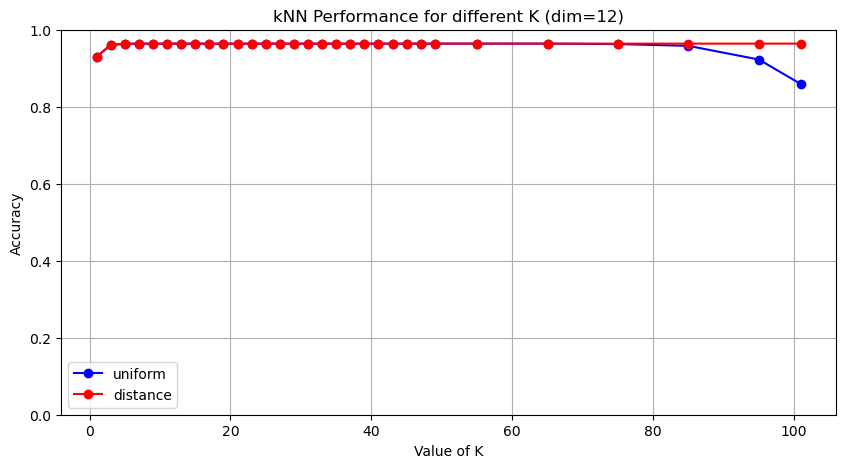

In [19]:
plot_optimal_k(12, krange)

### kryptonite-15

Loaded dataset with dimension 15. Data shape: (30000, 15), Labels shape: (30000,)


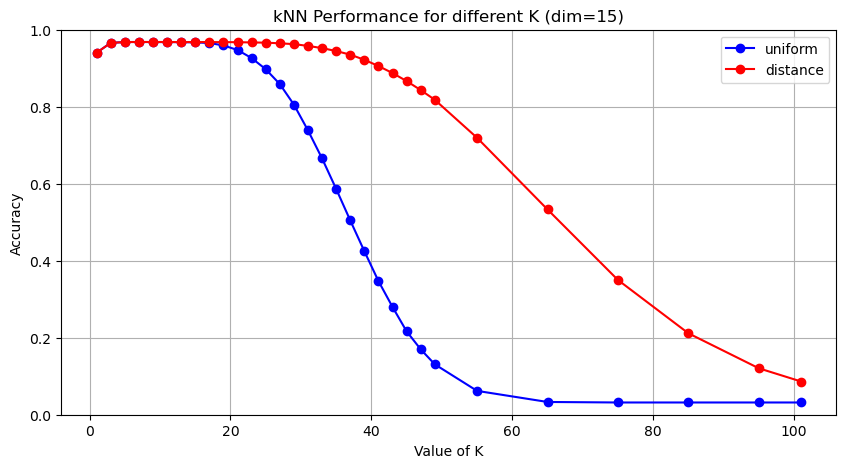

In [20]:
plot_optimal_k(15, krange)

### kryptonite-18

Loaded dataset with dimension 18. Data shape: (36000, 18), Labels shape: (36000,)


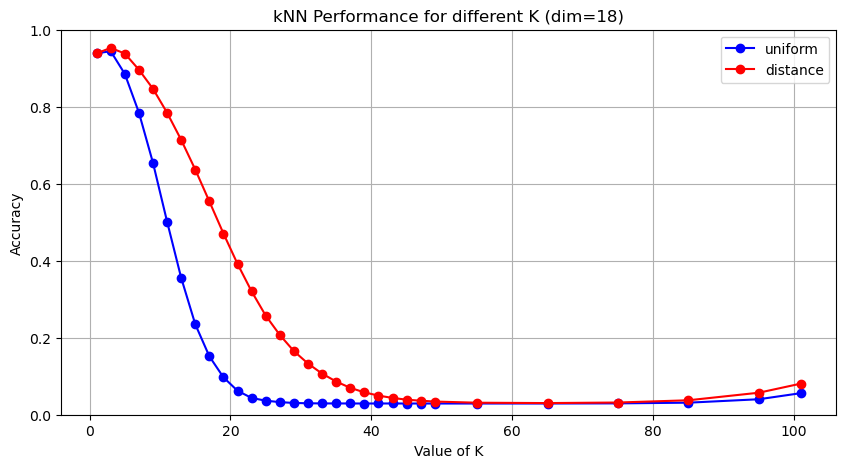

In [21]:
plot_optimal_k(18, krange)

### kryptonite-24


Loaded dataset with dimension 24. Data shape: (48000, 24), Labels shape: (48000,)


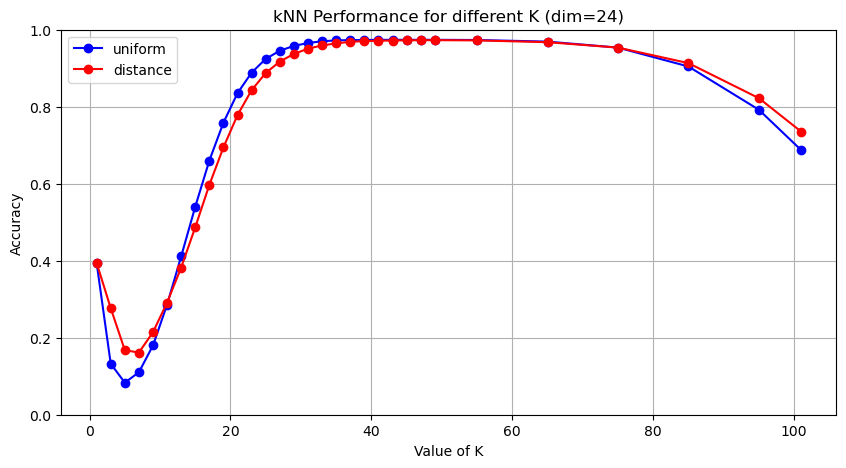

In [22]:
plot_optimal_k(24, krange)

### kryptonite-30

Loaded dataset with dimension 30. Data shape: (60000, 30), Labels shape: (60000,)


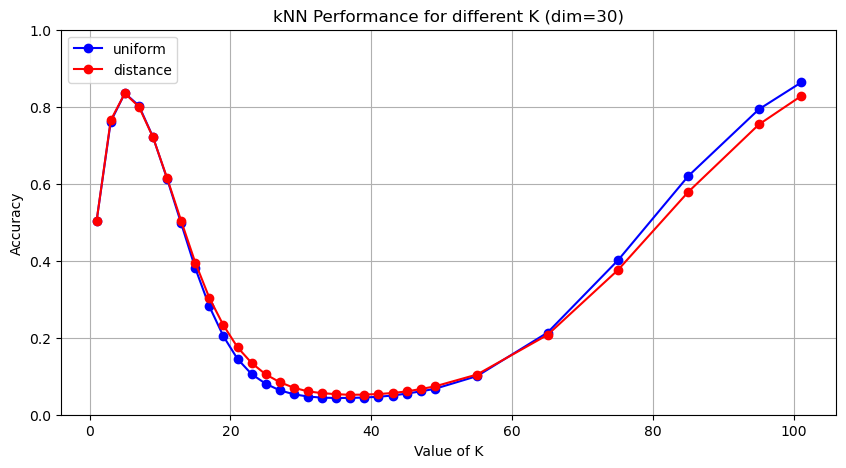

In [23]:
plot_optimal_k(30, krange)
# the model basically predicts the label the datapoint is not in at k-39, thus should flip the output

### kryptonite-45

Loaded dataset with dimension 45. Data shape: (90000, 45), Labels shape: (90000,)


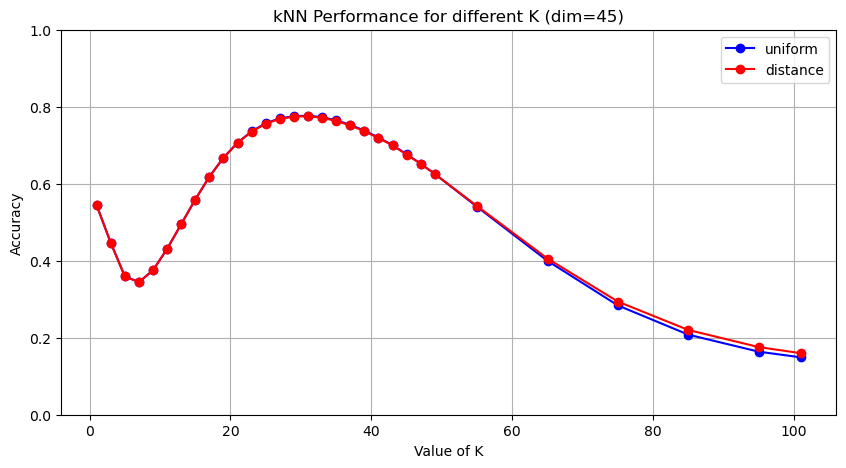

In [24]:
plot_optimal_k(45, krange)

## Evaluation

In [75]:
dimensions = [9, 12, 15, 18, 24, 30, 45]
best_ks = [9, 9, 7, 3, 47, 39, 31]
means_distance = []
std_devs_distance = []
random_seeds = [42, 123, 456, 789, 1010, 2020, 3030, 4040, 5050, 6060]
for dim, k in zip(dimensions, best_ks):
    data, labels = load_data_by_dimension(dim)
    data = preprocess_data(data, variance_threshold=0.253)
    accuracies = []
    for seed in random_seeds:
        X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=seed)
        model = KNeighborsClassifier(n_neighbors=k, weights="distance")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        if dim in [
            30]:  # the model basically predicts the label the datapoint is not in at dim=30 and k=45, thus should flip the output
            y_pred = 1 - y_pred
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    means_distance.append(np.mean(accuracies))
    std_devs_distance.append(np.std(accuracies))

Loaded dataset with dimension 9. Data shape: (18000, 9), Labels shape: (18000,)
Loaded dataset with dimension 12. Data shape: (24000, 12), Labels shape: (24000,)
Loaded dataset with dimension 15. Data shape: (30000, 15), Labels shape: (30000,)
Loaded dataset with dimension 18. Data shape: (36000, 18), Labels shape: (36000,)
Loaded dataset with dimension 24. Data shape: (48000, 24), Labels shape: (48000,)
Loaded dataset with dimension 30. Data shape: (60000, 30), Labels shape: (60000,)
Loaded dataset with dimension 45. Data shape: (90000, 45), Labels shape: (90000,)


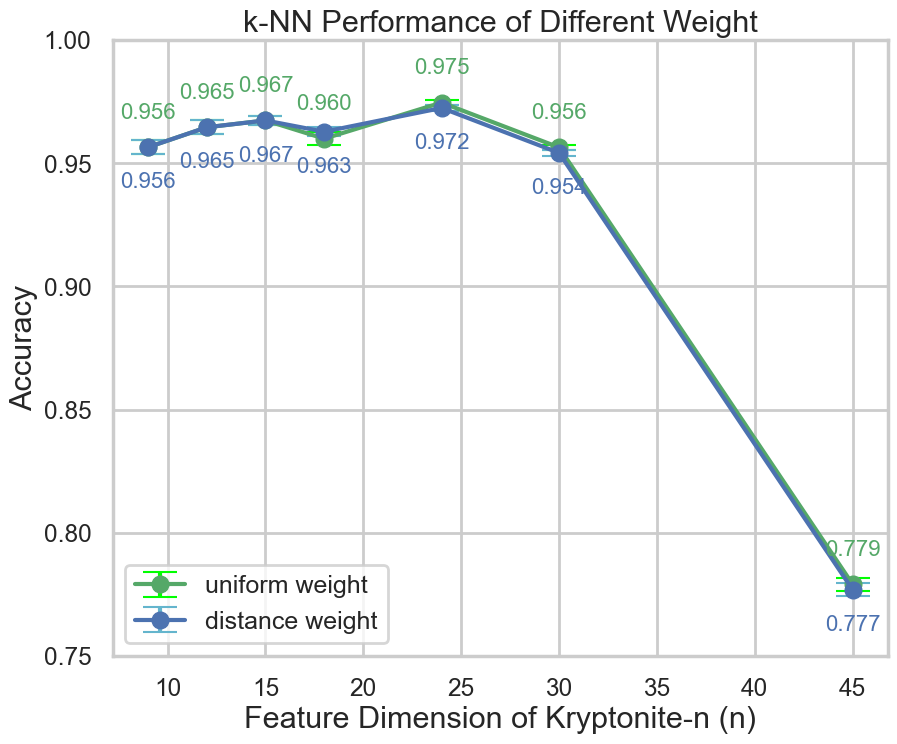

In [105]:
n = [9, 12, 15, 18, 24, 30, 45]
plt.rcdefaults()
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")
sns.set_context("poster", font_scale=0.8)
plt.errorbar(n, means_reduction, label='uniform weight', yerr=std_devs_reduction, marker='o', linestyle='-', color='g',
             ecolor='lime', capsize=12, capthick=1.5)
plt.errorbar(n, means_distance, label='distance weight', yerr=std_devs_distance, marker='o', linestyle='-', color='b',
             ecolor='c', capsize=12, capthick=1.5)

for x, y in zip(dimensions, means_distance):
    plt.text(x, y - 0.01, f'{y:.3f}', ha='center', va='top', color='b', fontsize=16)
for x, y in zip(dimensions, means_reduction):
    plt.text(x, y + 0.01, f'{y:.3f}', ha='center', va='bottom', color='g', fontsize=16)

plt.ylim(0.75, 1.)
plt.xlabel("Feature Dimension of Kryptonite-n (n)", fontsize=22)
plt.ylabel('Accuracy', fontsize=22)
plt.title('k-NN Performance of Different Weight', fontsize=22)
plt.grid(True)
plt.legend(fontsize=18, loc='lower left')
plt.show()

# Perdict new datasets

In [9]:
# best_ks=[9,5,5,3,35,45,35]
dimensions = [9, 12, 15, 18, 24, 30, 45]
root = "./datasets/"
for dim, k in zip(dimensions, best_ks):
    data, labels = load_data_by_dimension(dim)
    data = preprocess_data(data, variance_threshold=0.253)

    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(data, labels)

    data_filename = root + f'hidden-kryptonite-{dim}-X.npy'
    hidden_data = np.load(data_filename)
    hidden_data = preprocess_data(hidden_data, variance_threshold=0.253)
    y_pred = model.predict(hidden_data)
    if dim in [30]:
        y_pred = 1 - y_pred
    np.save(f'y_predicted_{dim}.npy', y_pred)

Loaded dataset with dimension 9. Data shape: (18000, 9), Labels shape: (18000,)
Loaded dataset with dimension 12. Data shape: (24000, 12), Labels shape: (24000,)
Loaded dataset with dimension 15. Data shape: (30000, 15), Labels shape: (30000,)
Loaded dataset with dimension 18. Data shape: (36000, 18), Labels shape: (36000,)
Loaded dataset with dimension 24. Data shape: (48000, 24), Labels shape: (48000,)
Loaded dataset with dimension 30. Data shape: (60000, 30), Labels shape: (60000,)
Loaded dataset with dimension 45. Data shape: (90000, 45), Labels shape: (90000,)
